## Airbus Turbine CLassification

    1. This is a Mini Project for Classifing Airbus Turbine/Background Images.
    2. There are two classes Turbine and Background.
    3. Dataset Link: https://www.kaggle.com/airbusgeo/airbus-wind-turbines-patches

### Import Libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import math
import pandas as pd
tf.__version__

'2.5.0'

In [21]:
from sklearn.metrics import  confusion_matrix # Confusion Matrix
import itertools  # itertools

### Rename Files to a Meaningful Name

#### Define Function to  Rename

In [2]:
def rename(directory, class_name, tvt):
    x = os.listdir(directory)
    for index, name in enumerate(x):
        name_new = f'{directory}{class_name}_{tvt}_{str(index)}.jpg'
        name = f'{directory}{name}'
        os.rename(name, name_new)

In [3]:
# Train
rename('airbus_turbines/train/background/', 'background', 'train')
rename('airbus_turbines/train/turbine/', 'turbine', 'train')

In [4]:
# Validation
rename('airbus_turbines/val/background/', 'background', 'val')
rename('airbus_turbines/val/turbine/', 'turbine', 'val')

In [6]:
# Test
rename('airbus_turbines/test/background/', 'background', 'test')
rename('airbus_turbines/test/turbine/', 'turbine', 'test')

### Read a Sample Image

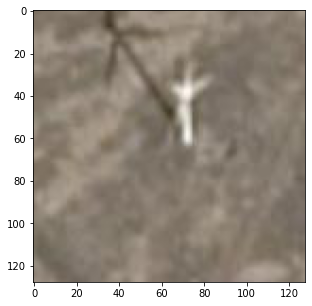

In [7]:
img_dir = 'airbus_turbines/train/turbine/turbine_train_0.jpg'
img = imread(img_dir)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()

In [8]:
# Look at the shape of the image
print('Shape of image: ', img.shape)

Shape of image:  (128, 128, 3)


### Parameter definition

In [4]:
batch_train = 100
batch_valid = 100
batch_test = 100
image_resize =64
num_classes = 2

### Datagenerator object

In [2]:
data_generator = ImageDataGenerator()

#### Train Set

In [11]:
train = data_generator.flow_from_directory('airbus_turbines/train/', 
                                           target_size = (image_resize,image_resize),
                                           batch_size = batch_train,
                                           class_mode = 'categorical')

Found 356006 images belonging to 2 classes.


#### Validation Set

In [12]:
valid = data_generator.flow_from_directory('airbus_turbines/val/', 
                                           target_size = (image_resize,image_resize),
                                           batch_size = batch_valid,
                                           class_mode = 'categorical')

Found 60174 images belonging to 2 classes.


### Model

In [13]:
model = tf.keras.Sequential()

In [14]:
model.add(tf.keras.layers.InputLayer(input_shape = (64, 64, 3)))
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1/255.))
model.add(tf.keras.layers.Convolution2D(64, 4, activation = 'relu', padding = 'valid'))
model.add(tf.keras.layers.Convolution2D(64, 4, activation = 'relu', padding = 'valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), padding = 'valid'))
model.add(tf.keras.layers.Convolution2D(64, 4, activation = 'relu', padding = 'valid'))
model.add(tf.keras.layers.Convolution2D(64, 4, activation = 'relu', padding = 'valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), padding = 'valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(num_classes, activation = 'sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 61, 64)        3136      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        65600     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0

#### Compile Model

In [16]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

#### Callbacks Files

In [17]:
csv_file = 'training.csv' # CSV File logger

#### Stopping Callback

In [18]:
class StopOnThreshold(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(StopOnThreshold, self).__init__()
        self.threshold = threshold
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs['val_categorical_accuracy']
        if val_acc >= self.threshold:
            print(f'Stopping Training! Validation Accuracy Reached Threshold of {val_acc*100}.')
            self.model.stop_training = True
# Call
stop_on_threshold = StopOnThreshold(0.97)

#### Fit Model

In [20]:
history = model.fit(train, epochs = 10, verbose = 1, validation_data= valid, callbacks=[tf.keras.callbacks.CSVLogger(csv_file), stop_on_threshold])

Epoch 1/10
3561/3561 [==============================] - 42723s 12s/step - loss: 0.0526 - categorical_accuracy: 0.9819 - val_loss: 0.0240 - val_categorical_accuracy: 0.9916
Stopping Training! Validation Accuracy Reached Threshold of 99.15910363197327.


### Save Model

In [21]:
tf.keras.models.save_model(model, "Model.model", overwrite=True, include_optimizer=True) 

INFO:tensorflow:Assets written to: Model.model\assets


### Plot Accuracy and Losses

In [ ]:
def plot(history, string):
    plt.figure(figsize=(10,7))
    plt.plot(history.history[string], label=string , color = 'red')
    plt.plot(history.history['val_'+string], label='val_'+string, color = 'green')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Epochs', fontdict={'fontsize':14})
    plt.ylabel(string, fontdict={'fontsize':14})
    plt.title(f'Epochs v/s {string}', fontdict={'fontsize':18})
    plt.show()
    return None
# Call
plot(history, 'loss')
plot(history, 'categorical_accuracy')

In [24]:
df=pd.read_csv('training.csv')
df.head()

,epoch,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0,0.981947,0.05263,0.991591,0.024021


#### Test Set 

In [25]:
test = data_generator.flow_from_directory('airbus_turbines/test/', 
                                           target_size = (image_resize,image_resize),
                                           batch_size = batch_test,
                                           class_mode = 'categorical', shuffle=False)

Found 11120 images belonging to 2 classes.


### Load Model

In [6]:
model = tf.keras.models.load_model('Model.model') # Load Model

### Evaluate Model

In [26]:
eval_model = model.evaluate(test, verbose = 1) # Evaluate

112/112 [==============================] - 108s 962ms/step - loss: 0.0265 - categorical_accuracy: 0.9913


In [27]:
print('Performance: ', eval_model[1]) 

Performance:  0.9912769794464111


### Predict Model

#### Read Image

In [9]:
import cv2

In [10]:
img_dir1 = 'airbus_turbines/test/turbine/turbine_test_100.jpg'
img_dir2 = 'airbus_turbines/test/background/background_test_121.jpg'

#### Function to Predict any Class

In [11]:
def predict(img_dir, class_real=None):
    # Read image
    img = cv2.imread(img_dir)
    print(f'Reality: This image is a {class_real}')
    
    # Show Image
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Prediction
    img = tf.image.resize(img, size=(image_resize, image_resize)) # Resize To Tensor
    img = np.expand_dims(img, axis=0) # Expand to 4-D
    y_pred = model.predict(img, verbose=0) # Predict
    labels = (test.class_indices) # Get Labels
    labels_rev = dict((v,k) for k,v in labels.items()) # Reverese Labels Items
    y_index = np.argmax(y_pred) # Get Index of maximum
    print(f'Prediction: This image is a {str(labels_rev[y_index])}.') # Print Class
    print(f'Prediction Accuracy: {np.around(max(y_pred[0]), 4)*100}%') # Print Accuracy

#### Turbine Class

Reality: This image is a Turbine


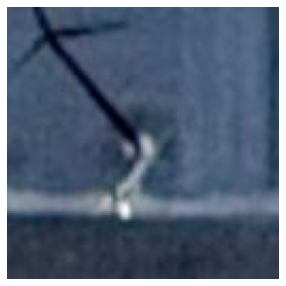

Prediction: This image is a turbine.
Prediction Accuracy: 100.0%


In [12]:
predict(img_dir1, 'Turbine')

#### Background Class

Reality: This image is a Background


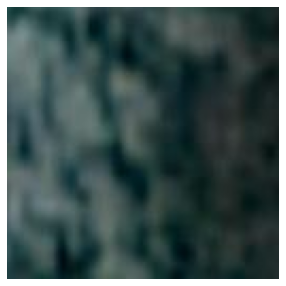

Prediction: This image is a background.
Prediction Accuracy: 99.94999766349792%


In [13]:
predict(img_dir2, 'Background')

### Confusion Matrix

In [28]:
y_pred = model.predict(test, verbose=1) # Predict

112/112 [==============================] - 113s 1s/step


In [29]:
y_pred = np.argmax(y_pred, axis=1) # Get the index maximum probability

In [30]:
# Get the names of labels for confusion Matrix
target_names = []
for key in test.class_indices:
    target_names.append(key.capitalize())

#### Helper Function to plot Confusion Matrix

In [47]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """ This function prints and plots the confusion matrix. """

    plt.figure(figsize=(16,8)) # Figure 
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # Plot Image
    plt.title(title, fontdict={'fontsize':24}) # Title
    plt.colorbar()   # Show Colorbar
    tick_marks = np.arange(len(classes)) # Array with elements as nuber of classes i.e. [0,1,2,3,4]
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14, fontweight='semibold') # X-Ticks as class names
    plt.yticks(tick_marks, classes, fontsize=14, fontweight='semibold') # Y-Ticks as class names
    
    # Show the number of classified images in the Confusion Matrix Box
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", 
                 color="black" if cm[i, j] > thresh else "black", fontsize=14, fontweight='semibold')
    
    plt.tight_layout() # Tight Layout
    plt.ylabel('True label', fontdict={'fontsize':18}) # Y-label
    plt.xlabel('Predicted label', fontdict={'fontsize':18}) # X-label
    plt.show() # Show 

#### Plot Confusion Matrix

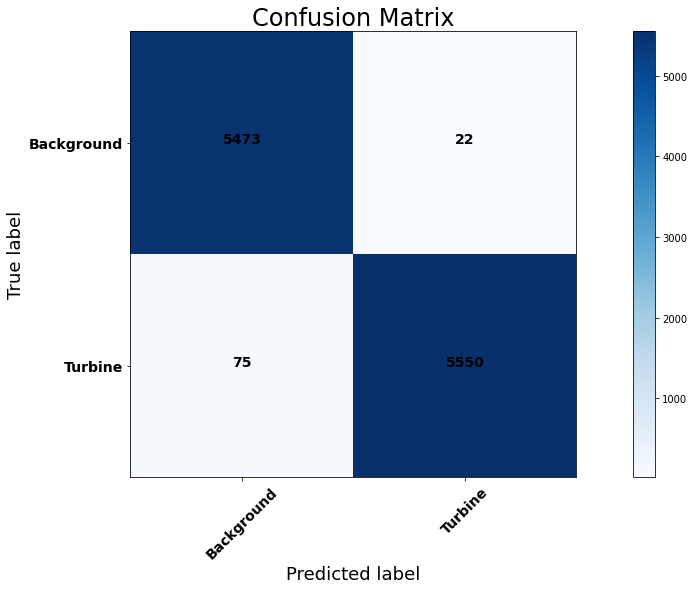

In [48]:
cm = confusion_matrix(test.classes, y_pred) # Confusion Matrix Array
plot_confusion_matrix(cm, target_names, title='Confusion Matrix') # Plot CM